<h1 align="center"><font size="5"> SVM Model for Text Classification</font></h1>
<h1 align="center"><font size="3"> by Sue</font></h1>

<h1 align="left"><font size="3">README  </font></h1>
This notebook contains SVM model setup. This SVM model can perform text classfication for the transaction category.
It will be persist using joblib and save as 'text_SVM_clf.pkl'.

Lets first import required libraries:

In [1]:
#might need to uncomment and install the joblib and pymysql libraries if you have not installed these before、
#!conda install -c conda-forge joblib -y
#!conda install -c conda-forge pymysql -y

In [39]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.externals import joblib
from sklearn.feature_extraction import text 
import pymysql
import matplotlib.pyplot as plt

### Load Data From MySql

<hr>

### _Function get_mysql_data_
- Parameters: string object that contains sql query
- Returns   : Dataframe object 
- Does      : base on the query to get data from mysql

In [3]:
def get_mysql_data(sql):
    """
    Extract the data from MySQL and Transform the data into DataFrame type
    parameter 'sql' means the MySQL query language, which is the only input of this function

    """
    conn = pymysql.connect(
        host='intern-dashboard.comal2agallf.us-east-1.rds.amazonaws.com',
        user='intern_dashboard',
        password='yEWAECzbMQma6yl3c6H9',
        db='innodb',
        port=3306
    )
    cur = conn.cursor()  # get the cursor, representing the beginning of operation
    sql_select = sql  # import the query language
    cur.execute(sql_select)  # excute the query language

    result = cur.fetchall()  # get the output of the query
    col_result = cur.description  # get the description of all the columns

    columns = []
    for i in range(len(col_result)):
        columns.append(col_result[i][0])  # get the column names and save the names in a list style

    df = pd.DataFrame(columns=columns)
    for i in range(len(result)):
        df.loc[i] = list(result[i])  # insert the data into the dataframe by rows

    conn.close()  # close the connecter to the database

    return df

### _Function generate_Data_
- Parameters: num is the integer value that represent the number of lines acquires from a single category
- Returns   : Dataframe object 
- Does      : generate the training data set from the mysql database

In [4]:
def generate_Data(num):
    unique_Category = get_mysql_data("SELECT distinct category FROM transactions").category.tolist()
    df = pd.DataFrame(data = {'class_method': [], 'description': [],'is_confirm_client': [], 'is_confirm': [], 'category': []})
    for x in unique_Category: 
        x = x.replace("'", "\\'")
        sql = "SELECT class_method,description,is_confirm,is_confirm_client, category From transactions where category = '" + str(x) + "' LIMIT " + str(num)
        df_temp = get_mysql_data(sql)
        #print(df_temp)
        df = df.merge(df_temp,how = "outer")
    return df


In [5]:
#df = %time generate_Data(1)
#x = 306
#sql = "SELECT class_method,description,is_confirm,is_confirm_client, category From transactions where user_id = " + str(x) 
#sample = get_mysql_data(sql)
#sample


### Load Data From CSV File  
<hr>

In [66]:
df = pd.read_csv('data/ml(new).CSV')
df.describe()

,id,balances,mask,account_owner,amount,category_id,client_category,cpa_category,ml_accuracy,bank_accts_id,user_id,is_confirm,is_confirm_client,note
count,411.000000,411.000000,411.0,0.0,411.000000,4.110000e+02,0.0,0.0,279.0,411.000000,411.0,411.0,411.0,0.0
mean,17216.824818,1383.172871,2740.0,NaN,-1223.919002,2.026842e+07,NaN,NaN,0.0,2.036496,306.0,1.0,0.0,NaN
std,3741.320669,407.743976,0.0,NaN,2779.878393,1.856439e+06,NaN,NaN,0.0,7.138773,0.0,0.0,0.0,NaN
min,4378.000000,1205.600000,2740.0,NaN,-14809.000000,1.200900e+07,NaN,NaN,0.0,0.000000,306.0,1.0,0.0,NaN
25%,17925.500000,1205.600000,2740.0,NaN,-1167.785000,2.100600e+07,NaN,NaN,0.0,0.000000,306.0,1.0,0.0,NaN
50%,18357.000000,1205.600000,2740.0,NaN,-303.000000,2.100600e+07,NaN,NaN,0.0,0.000000,306.0,1.0,0.0,NaN
75%,18819.500000,1205.600000,2740.0,NaN,-128.900000,2.100600e+07,NaN,NaN,0.0,0.000000,306.0,1.0,0.0,NaN
max,19431.000000,2709.210000,2740.0,NaN,25000.000000,2.101100e+07,NaN,NaN,0.0,27.000000,306.0,1.0,0.0,NaN


In [7]:
df['category'].unique()

array(['Office Expense', 'Commission Expense', 'Contractor',
       'Marketing Expense', 'Sales Revenue'], dtype=object)

<h2 id="preprocessing">Data pre-processing and selection</h2>
<hr>

In [63]:
df = df[['class_method','description','is_confirm','is_confirm_client','category']]

df = df.dropna(subset= ['description'])

In [9]:
#remove class method equal to "ML" that is_confirm = 0
df_temp = df[(df['class_method'] == 'ML') & (df['is_confirm'] == 1.0)]
#remove class method equal to "ML" that is_confirm_client = 0
df_confirm = df[(df['class_method'] == 'ML') & (df['is_confirm_client'] == 1.0)]
#merge the two type of confirm data
df_confirm = df_temp.merge(df_confirm, how = "outer" )

In [10]:
print('number of data each category')
total = 0
for x in df_confirm['category'].unique() :
    print(x, len(df_confirm[df_confirm['category'] == x]))
    total = total + len(df_confirm[df_confirm['category'] == x])
print('total:' , total)

number of data each category
Office Expense 1616
Commission Expense 924
Contractor 390
Marketing Expense 21
Sales Revenue 49
total: 3000


### _Function CategorySizePieChart_
- Parameters: dataframe that will be plot
- Returns   : None
- Does      : Plot the dataframe base on its category szie

In [11]:
def CategorySizePieChart(df):
    labels = df['category'].unique()
    sizes = [len(df[df['category'] == x]) for x in labels]

    fig1, ax= plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"))
    

    wedges, texts, autotexts = ax.pie(sizes, autopct='%1.1f%%',
                                  textprops=dict(color="w"),  startangle=90)

    ax.legend(wedges, labels,
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("data in each category: a pie")
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()


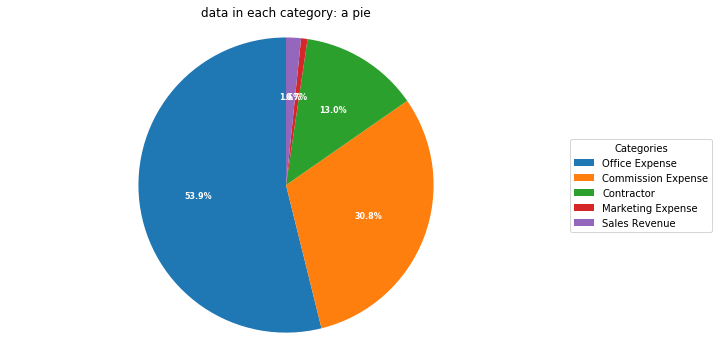

In [12]:
CategorySizePieChart(df_confirm)

In [13]:
print('unique description for each category')
for x in df_confirm['category'].unique() :
    print(x, len(df_confirm[df_confirm['category'] == x]['description'].unique()))
#max_num = np.amax([len(df[df['category']== x]['description'].unique()) for x in category_set])

unique description for each category
Office Expense 105
Commission Expense 1
Contractor 4
Marketing Expense 1
Sales Revenue 1


### _Function balanceCategorySize_
- Parameters: dataframe that need to be balance
- Returns   : dataframe that every category size is at least the mean
- Does      : enlarge category that size is less than average

In [14]:
def balanceCategorySize(df):
    category_set = df['category'].unique()
    avg = np.mean([len(df[df['category'] == x]) for x in category_set])
    df_balanced = pd.DataFrame( columns= df.columns)
    for category in category_set:
        x = df[df['category']== category]
        new_x = x
        while(len(new_x) < avg):
            new_x = pd.concat([new_x,x])
        df_balanced = pd.concat([df_balanced, new_x])
    return df_balanced


,class_method,description,is_confirm,is_confirm_client,category
0,ML,"DEBIT CARD PURCHASE, AUT 070419 VISA DDA PUR",1.0,0.0,Office Expense
1,ML,"DEBIT CARD PURCHASE, AUT 070419 VISA DDA PUR",1.0,0.0,Office Expense
2,ML,"DEBIT CARD PURCHASE, AUT 070419 VISA DDA PUR",1.0,0.0,Office Expense
3,ML,"DEBIT CARD PURCHASE, AUT 070419 VISA DDA PUR",1.0,0.0,Office Expense
4,ML,"DEBIT CARD PURCHASE, AUT 070419 VISA DDA PUR",1.0,0.0,Office Expense


In [ ]:
#让数据分布更均衡
df_balance = balanceCategorySize(df_confirm)
df_balance.head()

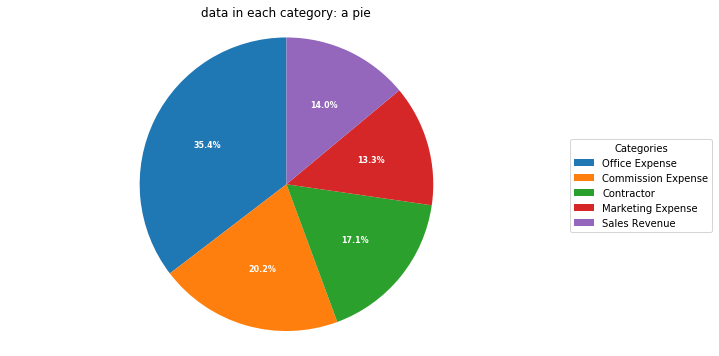

In [15]:
CategorySizePieChart(df_balance)

In [16]:
#save df_balace as df_confirm
df_confirm = df_balance

### _Function Enlarge_data_
- Parameters: 
              1. df: dataframe that need to be enlarge
              2. int size: the minimum size that user wants; default is 5000
- Returns   : dataframe that has length > size
- Does      : enlarge length of the dataframe to greater than or equal to 5000

In [17]:
def Enlarge_data(df, size = 5000):
    print('Data size w/out unconfirm data: ',len(df),'\n')
    df_large = df
    while(len(df_large) < size):
        df_large = pd.concat([df_large,df])

    print('Current data size',len(df_large))
    return df_large

In [18]:
df_clean = Enlarge_data(df_confirm, 6000)

Data size w/out unconfirm data:  4566 

Current data size 9132


In [19]:
#testing for adding unknown value
#df_unknown = df_clean[df_clean['category'] == 'Office Expense']
#df_clean = df_clean[df_clean['category'] != 'Office Expense']
#df_unknown.head()

### _Function get_stopwords_
- Parameters: the path to find the stopword file
- Returns   : a set of the stopwords
- Does      : generate a set of stopwords from the given file

In [20]:
def get_stopwords(stop_file_path):
    #load stop words  
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

In [21]:
#Todo: 1. find more stopwords
#load a set of stop words
additional_stopwords=get_stopwords("assets/stopwords.txt")

stopwords = text.ENGLISH_STOP_WORDS.union(additional_stopwords)
#stopwords

In [22]:
#uncomment the line below to see description before clean
df_clean["description"].unique().tolist()

['DEBIT CARD PURCHASE, AUT 070419 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 040119 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 040219 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 051419 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 020619 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 040519 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 030619 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 022119 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 082119 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 082619 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 081919 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 012619 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 060819 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 052319 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 080219 VISA DDA PUR',
 'DEBIT CARD CREDIT, AUT 041919 VISA DDA REF',
 'DEBIT CARD PURCHASE, AUT 030419 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 052819 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 080919 VISA DDA PUR',
 'DEBIT CARD PURCHASE, AUT 071619 VISA DDA PUR',
 'DEBIT CARD PURCHASE,

In [23]:
#remove all the puntuation/number
df_clean["clean_description"] = df_clean['description'].str.replace('\d{2,}|[^\w\s]','')
df_clean = df_clean.drop(columns = 'description')
df_clean = df_clean.rename(columns={'clean_description': 'description'})
df_clean[118:125]

,class_method,is_confirm,is_confirm_client,category,description
1042,ML,1.0,0.0,Office Expense,DEBIT CARD PURCHASE AUT VISA DDA PUR
1043,ML,1.0,0.0,Office Expense,DEBIT CARD PURCHASE AUT VISA DDA PUR
1044,ML,1.0,0.0,Office Expense,DEBIT CARD PURCHASE AUT VISA DDA PUR
1045,ML,1.0,0.0,Office Expense,DEBIT CARD PURCHASE AUT VISA DDA PUR
1046,ML,1.0,0.0,Office Expense,DEBIT CARD PURCHASE AUT VISA DDA PUR
1047,ML,1.0,0.0,Office Expense,DEBIT CARD PURCHASE AUT VISA DDA PUR
1048,ML,1.0,0.0,Office Expense,DEBIT CARD PURCHASE AUT VISA DDA PUR


In [24]:
#uncomment the line to check on the clean description
df_clean["description"].unique().tolist()

['DEBIT CARD PURCHASE AUT  VISA DDA PUR',
 'DEBIT CARD CREDIT AUT  VISA DDA REF',
 'VISA DDA PUR  PAYPAL LUCKYORANGE ',
 'VISA DDA PUR  INTUIT QUICKBOOKS ',
 'DEBIT',
 'Venmo',
 'VISA DDA PUR  PAYPAL BRIAN ',
 'VISA DDA PUR  PAYPAL MAGDINAALLA VISA DIRECT ',
 'VISA DDA REF  UPWORK JOBPOST   ',
 'VISA DDA PUR  BLS SEMRUSH ',
 'eTransfer Credit Online Xfer']

In [25]:
print()

## Train/Test dataset for Description
<hr>

In [26]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_clean['description'], 
                                                    df_clean['category'], 
                                                    random_state=3, test_size = 0.3)

In [ ]:
#print(df)

In [27]:
print('\ny_train shape: ', y_train.shape, '\n\nX_train shape: ', X_train.shape)
print('\ny_test shape: ', y_test.shape, '\n\nX_test shape: ', X_test.shape)


y_train shape:  (6392,) 

X_train shape:  (6392,)

y_test shape:  (2740,) 

X_test shape:  (2740,)


<h2 id="#modeling">Modeling</h2>
<hr>

In [28]:
#Todo: 1. 对parameter 有更多调整
#         a. 例如countVectorizer dictionary，df max and min
vect = CountVectorizer(min_df=2,strip_accents='unicode',lowercase =True,
                            analyzer='word', token_pattern=r'\w+',stop_words = stopwords)
tfdif = TfidfTransformer()
svc = svm.LinearSVC(C=1.0,penalty='l2',loss='squared_hinge')
svc

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [29]:
#create pipeline for text classification
text_clf = Pipeline([
    ('vect', vect),
    ('tfidf', tfdif),
    ('svc', svc)
    
])

In [30]:
text_clf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=frozenset({'"', '#', ',', '/', 'a',
                                                       'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'a...
                                 strip_accents='unicode', token_pattern='\\w+',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
 

In [31]:
#print(len(vect.get_feature_names()))
#print(svc.intercept_)
#print(len(svc.coef_[1]))
print(svc.classes_)
#print(vect.get_feature_names())

['Commission Expense' 'Contractor' 'Marketing Expense' 'Office Expense'
 'Sales Revenue']


### _Function predict_
- Parameters: a decision_function array of the pre-trained data and a list of class names
- Returns   : prediction for the object
- Does      : Perform classification on samples in decision function.

In [32]:
def predict(decision_func,cs):
    ''' decision_fun = decision function
        cs = list of class names      
    '''
    count = 0
    pred = [None] * len(decision_func)
    confidence=[None]*len(decision_func[0])
    for transaction in decision_func:
        num_confident = 0
        for idx in range(len(transaction)):
            confidence_score = transaction[idx]
            if(confidence_score > 0):
                confidence[idx] = confidence_score
                pred[count] = cs[idx];
                num_confident += 1;
            else:
                confidence[idx] = 0
            
            # find std deviation of x if std dev is < 0.4
        if(num_confident != 1 and np.std(confidence)<0.4):
            pred[count] = 'unknown' 
        elif(num_confident != 1):
            pred[count] = cs[confidence.index(max(confidence))]
            
            
        count += 1
    return pred
            
    

In [33]:
decision_func = text_clf['svc'].decision_function(vect.transform(X_train))
cs = text_clf['svc'].classes_
temp= predict(decision_func,cs)
#print(temp)
print("Test set Accuracy: ", accuracy_score(predict(decision_func,cs), y_train))

Test set Accuracy:  1.0


<h2 id="#model Persistence">Model Persistence</h2>
<hr>
use joblib’s dump & load to persist the SVM model.

In [34]:
joblib.dump(text_clf,'Model/text_SVM_clf.pkl')

['Model/text_SVM_clf.pkl']

<h2 id="#model evaluation">Model Evaluation</h2>
<hr>
load back the pickled model

In [35]:
test_clf=joblib.load('Model/text_SVM_clf.pkl')
pred = test_clf.predict(X_test)
print("Test set Accuracy: ", accuracy_score(y_test, pred))

Test set Accuracy:  1.0


# cross val score

In [42]:
#Using Cross Validation to evaluate model
from sklearn.model_selection import cross_val_score
result = cross_val_score(text_clf,df_clean['description'],df_clean['category'],cv=5)
print('Evaluation on the accuracy:%.3f%%(%.3f%%)'%(result.mean()*100,result.std()*100))

Evaluation on the accuracy:100.000%(0.000%)


# confusion_matrix

A = {'Contractor', 'Office Expense', 'Commission Expense','Marketing Expense','Sales Revenue'...}
a is element of A
* True Positive (TP): the model predicted that a category is A and it actually is.
* True Negative (TN): the model predicted that a category is not A and it actually is not.
* False Positive (FP): the model predicted that a category is A but it actually is not. - type 1 error -
* False Negative (FN): the model predicted that a categrory is not A but it actually is. - type 2 error -

In [36]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, pred, labels = svc.classes_)

array([[532,   0,   0,   0,   0],
       [  0, 461,   0,   0,   0],
       [  0,   0, 387,   0,   0],
       [  0,   0,   0, 992,   0],
       [  0,   0,   0,   0, 368]])

In [37]:
#from sklearn.metrics import multilabel_confusion_matrix
#multilabel_confusion_matrix(y_test, pred, labels = df_clean['category'].unique())

* Precision: TP/(TP + FP); the ratio of correctly predicted positive categories to the total predicted positive categories. 
* Recall: TP/(TP + FN); the ratio of correctly predicted positive categories to the all categories in actual class

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

Commission Expense       1.00      1.00      1.00       532
        Contractor       1.00      1.00      1.00       461
 Marketing Expense       1.00      1.00      1.00       387
    Office Expense       1.00      1.00      1.00       992
     Sales Revenue       1.00      1.00      1.00       368

          accuracy                           1.00      2740
         macro avg       1.00      1.00      1.00      2740
      weighted avg       1.00      1.00      1.00      2740



# Parameter tuning using grid search

In [56]:
from sklearn.model_selection import GridSearchCV
param = {'svc__C':np.arange(0.01,10),
        #'svc__penalty': ['l1', 'l2'],
        'vect__ngram_range': [(1, 1), (1, 2)],
        'tfidf__use_idf': (True, False)}
linearSVC = GridSearchCV(test_clf,param,cv=5,return_train_score=True)
linearSVC.fit(X_train,y_train)
print(linearSVC.best_params_)

{'svc__C': 1.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}
